In [1]:
import synapseclient
from synapseclient import Project, File, Folder
from synapseclient import Schema, Column, Table, Row, RowSet, as_table_columns
import itertools
import pandas as pd
import numpy as np

In [2]:
syn = synapseclient.Synapse()
syn.login()

Welcome, Victor Baham!



In [3]:
divco_bio = pd.read_csv(syn.get('syn51757645').path)
rosmap_bio = pd.read_csv(syn.get('syn21323366').path)
mayo_bio = pd.read_csv(syn.get('syn20827192').path)
msbb_bio = pd.read_csv(syn.get('syn21893059').path)

#### Collapse tissue types into broader categories

In [4]:
tissue_to_category = {'occipital visual cortex': 'visual cortex', 
                     'parahippocampal gyrus': 'temporal cortex',
                     'posterior cingulate cortex': 'cingulate cortex',
                     'serum': 'blood',
                     'Head of caudate nucleus': 'caudate nucleus',
                     'caudate nucleus': 'caudate nucleus',
                     'cerebellar cortex': 'cerebellum',
                     'dorsolateral prefrontal cortex': 'prefrontal cortex',
                     'frontal pole': 'frontal cortex',
                     'inferior frontal gyrus': 'frontal cortex',
                     'superior temporal gyrus': 'temporal cortex',
                     'temporal pole': 'temporal cortex'}

In [5]:
rosmap_bio['specimenMetadataSource'] = 'ROSMAP'
mayo_bio['specimenMetadataSource'] = 'MayoRNAseq'
msbb_bio['specimenMetadataSource'] = 'MSBB'

In [6]:
mega_bio = pd.concat([divco_bio, rosmap_bio, mayo_bio, msbb_bio], ignore_index=True)
mega_bio['tissue'] = mega_bio['tissue'].apply(lambda x: tissue_to_category.get(x) if x 
                                              in tissue_to_category.keys() else x)
mega_bio

[WARNING] /Users/vbaham/opt/anaconda3/lib/python3.9/site-packages/IPython/lib/pretty.py:700: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)

[WARNING] /Users/vbaham/opt/anaconda3/lib/python3.9/site-packages/IPython/core/formatters.py:345: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()



individualID   specimenID dataGenerationSite  organ             tissue  \
0          NYBB_17   NYBB_17WGS               NYGC  brain  prefrontal cortex   
1         NYBB_147  NYBB_147WGS               NYGC  brain  prefrontal cortex   
2         NYBB_148  NYBB_148WGS               NYGC  brain  prefrontal cortex   
3         NYBB_153  NYBB_153WGS               NYGC  brain  prefrontal cortex   
4          NYBB_76   NYBB_76WGS               NYGC  brain  prefrontal cortex   
...            ...          ...                ...    ...                ...   
26048          NaN          NaN                NaN    NaN                NaN   
26049          NaN          NaN                NaN    NaN                NaN   
26050          NaN          NaN                NaN    NaN                NaN   
26051          NaN          NaN                NaN    NaN                NaN   
26052          NaN          NaN                NaN    NaN                NaN   

      BrodmannArea isPostMortem sampleStatus nucleicAcidSource  \
0              BA9         True       frozen         bulk cell   
1              BA9         True       frozen         bulk cell   
2              BA9         True       frozen         bulk cell   
3              BA9         True       frozen         bulk cell   
4              BA9         True       frozen         bulk cell   
...            ...          ...          ...               ...   
26048          NaN          NaN          NaN               NaN   
26049          NaN          NaN          NaN               NaN   
26050          NaN          NaN          NaN               NaN   
26051          NaN          NaN          NaN               NaN   
26052          NaN          NaN          NaN               NaN   

                assay  ... tissueVolume cellType  fastingState  samplingAge  \
0      wholeGenomeSeq  ...          NaN      NaN           NaN          NaN   
1      wholeGenomeSeq  ...          NaN      NaN           NaN          NaN   
2      wholeGenomeSeq  ...          NaN      NaN           NaN          NaN   
3      wholeGenomeSeq  ...          NaN      NaN           NaN          NaN   
4      wholeGenomeSeq  ...          NaN      NaN           NaN          NaN   
...               ...  ...          ...      ...           ...          ...   
26048             NaN  ...          NaN      NaN           NaN          NaN   
26049             NaN  ...          NaN      NaN           NaN          NaN   
26050             NaN  ...          NaN      NaN           NaN          NaN   
26051             NaN  ...          NaN      NaN           NaN          NaN   
26052             NaN  ...          NaN      NaN           NaN          NaN   

      samplingAgeUnits visitNumber exclude excludeReason  samplingDate  \
0                  NaN         NaN     NaN           NaN           NaN   
1                  NaN         NaN     NaN           NaN           NaN   
2                  NaN         NaN     NaN           NaN           NaN   
3                  NaN         NaN     NaN           NaN           NaN   
4                  NaN         NaN     NaN           NaN           NaN   
...                ...         ...     ...           ...           ...   
26048              NaN         NaN     NaN           NaN           NaN   
26049              NaN         NaN     NaN           NaN           NaN   
26050              NaN         NaN     NaN           NaN           NaN   
26051              NaN         NaN     NaN   sample swap           NaN   
26052              NaN         NaN     NaN   sample swap           NaN   

      Exclusion_Category  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
26048                NaN  
26049                NaN  
26050                NaN  
26051                NaN  
26052                NaN  

[26053 rows x 23 columns]

#### Find number of distinct specimens for each assay type:

#### *Without* grouping by `specimenMetadataSource`:

In [7]:
unique_specs_per_assay = mega_bio.groupby(['assay', 'specimenID'])['specimenID'].nunique()
unique_specs_per_assay_piv_1 = mega_bio.groupby(['assay', 'specimenID'],as_index = False).nunique().pivot('assay'
                    ,'specimenID').fillna(0)
unique_specs_per_assay_piv_2 = mega_bio.groupby(['specimenID', 'assay']).size().unstack('assay', fill_value=0.0)
unique_specs_per_assay_piv_2

[WARNING] /var/folders/lg/w3yckgy936lc0r6yw790hjs00000gr/T/ipykernel_27193/1207037233.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  unique_specs_per_assay_piv_1 = mega_bio.groupby(['assay', 'specimenID'],as_index = False).nunique().pivot('assay'



assay        10x multiome  ATACSeq  ATACseq  Biocrates Bile Acids  \
specimenID                                                          
01_120405             0.0      0.0      0.0                   0.0   
02_120405             0.0      0.0      0.0                   0.0   
03_120405             0.0      0.0      0.0                   0.0   
04_120405             0.0      0.0      0.0                   0.0   
05_120405             0.0      0.0      0.0                   0.0   
...                   ...      ...      ...                   ...   
sd_b25.131N           0.0      0.0      0.0                   0.0   
sd_b25.132C           0.0      0.0      0.0                   0.0   
sd_b25.132N           0.0      0.0      0.0                   0.0   
sd_b25.133C           0.0      0.0      0.0                   0.0   
sd_b25.133N           0.0      0.0      0.0                   0.0   

assay        Biocrates p180  ChIPSeq  Metabolon  TMT quantitation  exomeSeq  \
specimenID                                                                    
01_120405               0.0      0.0        0.0               0.0       0.0   
02_120405               0.0      0.0        0.0               0.0       0.0   
03_120405               0.0      0.0        0.0               0.0       0.0   
04_120405               0.0      0.0        0.0               0.0       0.0   
05_120405               0.0      0.0        0.0               0.0       0.0   
...                     ...      ...        ...               ...       ...   
sd_b25.131N             0.0      0.0        0.0               1.0       0.0   
sd_b25.132C             0.0      0.0        0.0               1.0       0.0   
sd_b25.132N             0.0      0.0        0.0               1.0       0.0   
sd_b25.133C             0.0      0.0        0.0               1.0       0.0   
sd_b25.133N             0.0      0.0        0.0               1.0       0.0   

assay        label free mass spectrometry  methylationArray  mirnaArray  \
specimenID                                                                
01_120405                             0.0               0.0         1.0   
02_120405                             0.0               0.0         1.0   
03_120405                             0.0               0.0         1.0   
04_120405                             0.0               0.0         1.0   
05_120405                             0.0               0.0         1.0   
...                                   ...               ...         ...   
sd_b25.131N                           0.0               0.0         0.0   
sd_b25.132C                           0.0               0.0         0.0   
sd_b25.132N                           0.0               0.0         0.0   
sd_b25.133C                           0.0               0.0         0.0   
sd_b25.133N                           0.0               0.0         0.0   

assay        rnaArray  rnaSeq  scrnaSeq  snpArray  wholeGenomeSeq  
specimenID                                                         
01_120405         0.0     1.0       0.0       0.0             0.0  
02_120405         0.0     1.0       0.0       0.0             0.0  
03_120405         0.0     1.0       0.0       0.0             0.0  
04_120405         0.0     1.0       0.0       0.0             0.0  
05_120405         0.0     1.0       0.0       0.0             0.0  
...               ...     ...       ...       ...             ...  
sd_b25.131N       0.0     0.0       0.0       0.0             0.0  
sd_b25.132C       0.0     0.0       0.0       0.0             0.0  
sd_b25.132N       0.0     0.0       0.0       0.0             0.0  
sd_b25.133C       0.0     0.0       0.0       0.0             0.0  
sd_b25.133N       0.0     0.0       0.0       0.0             0.0  

[19690 rows x 17 columns]

#### *With* grouping by `specimenMetadataSource`:

#### Note: This *barely* reduces the number of rows from the previous iteration, so it may not be worth the effort to group here

In [8]:
unique_specs_per_assay_by_source_piv = mega_bio.groupby(['specimenID', 'assay', 'specimenMetadataSource']).size().unstack('assay', fill_value=0.0)
unique_specs_per_assay_by_source_piv

assay                               10x multiome  ATACSeq  ATACseq  \
specimenID  specimenMetadataSource                                   
01_120405   ROSMAP                           0.0      0.0      0.0   
02_120405   ROSMAP                           0.0      0.0      0.0   
03_120405   ROSMAP                           0.0      0.0      0.0   
04_120405   ROSMAP                           0.0      0.0      0.0   
05_120405   ROSMAP                           0.0      0.0      0.0   
...                                          ...      ...      ...   
sd_b25.131N AMP-AD_DiverseCohorts            0.0      0.0      0.0   
sd_b25.132C AMP-AD_DiverseCohorts            0.0      0.0      0.0   
sd_b25.132N AMP-AD_DiverseCohorts            0.0      0.0      0.0   
sd_b25.133C AMP-AD_DiverseCohorts            0.0      0.0      0.0   
sd_b25.133N AMP-AD_DiverseCohorts            0.0      0.0      0.0   

assay                               Biocrates Bile Acids  Biocrates p180  \
specimenID  specimenMetadataSource                                         
01_120405   ROSMAP                                   0.0             0.0   
02_120405   ROSMAP                                   0.0             0.0   
03_120405   ROSMAP                                   0.0             0.0   
04_120405   ROSMAP                                   0.0             0.0   
05_120405   ROSMAP                                   0.0             0.0   
...                                                  ...             ...   
sd_b25.131N AMP-AD_DiverseCohorts                    0.0             0.0   
sd_b25.132C AMP-AD_DiverseCohorts                    0.0             0.0   
sd_b25.132N AMP-AD_DiverseCohorts                    0.0             0.0   
sd_b25.133C AMP-AD_DiverseCohorts                    0.0             0.0   
sd_b25.133N AMP-AD_DiverseCohorts                    0.0             0.0   

assay                               ChIPSeq  Metabolon  TMT quantitation  \
specimenID  specimenMetadataSource                                         
01_120405   ROSMAP                      0.0        0.0               0.0   
02_120405   ROSMAP                      0.0        0.0               0.0   
03_120405   ROSMAP                      0.0        0.0               0.0   
04_120405   ROSMAP                      0.0        0.0               0.0   
05_120405   ROSMAP                      0.0        0.0               0.0   
...                                     ...        ...               ...   
sd_b25.131N AMP-AD_DiverseCohorts       0.0        0.0               1.0   
sd_b25.132C AMP-AD_DiverseCohorts       0.0        0.0               1.0   
sd_b25.132N AMP-AD_DiverseCohorts       0.0        0.0               1.0   
sd_b25.133C AMP-AD_DiverseCohorts       0.0        0.0               1.0   
sd_b25.133N AMP-AD_DiverseCohorts       0.0        0.0               1.0   

assay                               exomeSeq  label free mass spectrometry  \
specimenID  specimenMetadataSource                                           
01_120405   ROSMAP                       0.0                           0.0   
02_120405   ROSMAP                       0.0                           0.0   
03_120405   ROSMAP                       0.0                           0.0   
04_120405   ROSMAP                       0.0                           0.0   
05_120405   ROSMAP                       0.0                           0.0   
...                                      ...                           ...   
sd_b25.131N AMP-AD_DiverseCohorts        0.0                           0.0   
sd_b25.132C AMP-AD_DiverseCohorts        0.0                           0.0   
sd_b25.132N AMP-AD_DiverseCohorts        0.0                           0.0   
sd_b25.133C AMP-AD_DiverseCohorts        0.0                           0.0   
sd_b25.133N AMP-AD_DiverseCohorts        0.0                           0.0   

assay                               methylationArray  mirnaArray  rnaArray  \
specimenID  specim

#### Find number of specimens of each tissue type for each assay type:

#### *Without* grouping by `specimenMetadataSource`:

In [9]:
unique_specs_per_assay_and_tissue = mega_bio.groupby(['assay', 'specimenID', 'tissue'])['specimenID'].count()
unique_specs_per_assay_and_tissue_piv = mega_bio.groupby(['assay', 'tissue'])['specimenID'].count().unstack('tissue', fill_value=0.0)
unique_specs_per_assay_and_tissue_piv

tissue                        blood  caudate nucleus  cerebellum  \
assay                                                              
10x multiome                    0.0            128.0         0.0   
ATACSeq                         0.0              0.0         0.0   
ATACseq                         0.0              0.0         0.0   
Biocrates Bile Acids            0.0              0.0         0.0   
Biocrates p180                597.0              0.0         0.0   
ChIPSeq                         0.0              0.0         0.0   
Metabolon                       0.0              0.0       182.0   
TMT quantitation                0.0              0.0         0.0   
exomeSeq                        0.0              0.0         0.0   
label free mass spectrometry    0.0              0.0         0.0   
methylationArray                0.0              0.0         0.0   
mirnaArray                      0.0              0.0         0.0   
rnaArray                        0.0              0.0         0.0   
rnaSeq                        615.0           1353.0       278.0   
scrnaSeq                        0.0              0.0         0.0   
snpArray                        0.0              0.0         8.0   
wholeGenomeSeq                390.0             56.0       269.0   

tissue                        cingulate cortex  frontal cortex  \
assay                                                            
10x multiome                               0.0             0.0   
ATACSeq                                    0.0             0.0   
ATACseq                                    0.0             0.0   
Biocrates Bile Acids                       0.0             0.0   
Biocrates p180                             0.0             0.0   
ChIPSeq                                    0.0             0.0   
Metabolon                                  0.0             0.0   
TMT quantitation                           0.0             0.0   
exomeSeq                                   0.0            83.0   
label free mass spectrometry               0.0             0.0   
methylationArray                           0.0             0.0   
mirnaArray                                 0.0             0.0   
rnaArray                                   0.0             0.0   
rnaSeq                                   671.0           618.0   
scrnaSeq                                   0.0             0.0   
snpArray                                   0.0             0.0   
wholeGenomeSeq                            68.0             2.0   

tissue                        prefrontal cortex  temporal cortex  unspecified  \
assay                                                                           
10x multiome                              135.0            136.0          0.0   
ATACSeq                                     0.0            636.0          0.0   
ATACseq                                     0.0            110.0          0.0   
Biocrates Bile Acids                      111.0              0.0          0.0   
Biocrates p180                            111.0              0.0          0.0   
ChIPSeq                                   712.0              0.0          0.0   
Metabolon                                 514.0            196.0          0.0   
TMT quantitation                         1505.0            470.0          0.0   
exomeSeq                                    0.0            263.0          0.0   
label free mass spectrometry             1494.0            199.0          0.0   
methylationArray                          748.0            201.0          0.0   
mirnaArray                                748.0              0.0          0.0   
rnaArray                                  492.0              0.0          0.0   
rnaSeq                                   2002.0           1886.0          0.0   
scrnaSeq                                  995.0              0.0          0.0   
snpArray                                    0.0            285.0          0

#### *With* grouping by `specimenMetadataSource`:

In [10]:
unique_specs_per_assay_and_tissue_by_source_piv = mega_bio.groupby(['assay', 'tissue', 'specimenMetadataSource'])['specimenID'].count().unstack('tissue', fill_value=0.0)
unique_specs_per_assay_and_tissue_by_source_piv

tissue                                               blood  caudate nucleus  \
assay                        specimenMetadataSource                           
10x multiome                 AMP-AD_DiverseCohorts     0.0            128.0   
ATACSeq                      MSBB                      0.0              0.0   
ATACseq                      MSBB                      0.0              0.0   
Biocrates Bile Acids         ROSMAP                    0.0              0.0   
Biocrates p180               ROSMAP                  597.0              0.0   
ChIPSeq                      ROSMAP                    0.0              0.0   
Metabolon                    MayoRNAseq                0.0              0.0   
                             ROSMAP                    0.0              0.0   
TMT quantitation             AMP-AD_DiverseCohorts     0.0              0.0   
                             MSBB                      0.0              0.0   
                             ROSMAP                    0.0              0.0   
exomeSeq                     MSBB                      0.0              0.0   
label free mass spectrometry MSBB                      0.0              0.0   
                             MayoRNAseq                0.0              0.0   
                             ROSMAP                    0.0              0.0   
methylationArray             MSBB                      0.0              0.0   
                             ROSMAP                    0.0              0.0   
mirnaArray                   ROSMAP                    0.0              0.0   
rnaArray                     ROSMAP                    0.0              0.0   
rnaSeq                       AMP-AD_DiverseCohorts     0.0            604.0   
                             MSBB                      0.0              0.0   
                             MayoRNAseq                0.0              0.0   
                             ROSMAP                  615.0            749.0   
scrnaSeq                     ROSMAP                    0.0              0.0   
snpArray                     MayoRNAseq                0.0              0.0   
wholeGenomeSeq               AMP-AD_DiverseCohorts     0.0             52.0   
                             MayoRNAseq                0.0              0.0   
                             ROSMAP                  390.0              4.0   

tissue                                               cerebellum  \
assay                        specimenMetadataSource               
10x multiome                 AMP-AD_DiverseCohorts          0.0   
ATACSeq                      MSBB                           0.0   
ATACseq                      MSBB                           0.0   
Biocrates Bile Acids         ROSMAP                         0.0   
Biocrates p180               ROSMAP                         0.0   
ChIPSeq                      ROSMAP                         0.0   
Metabolon                    MayoRNAseq                   182.0   
                             ROSMAP                         0.0   
TMT quantitation             AMP-AD_DiverseCohorts          0.0   
                             MSBB                           0.0   
                             ROSMAP                         0.0   
exomeSeq                     MSBB                           0.0   
label free mass spectrometry MSBB                           0.0   
                             MayoRNAseq                     0.0   
                             ROSMAP                         0.0   
methylationArray             MSBB                           0.0   
                             ROSMAP                         0.0   
mirnaArray                   ROSMAP                         0.0   
rnaArray                     ROSMAP                         0.0   
rnaSeq                       AMP-AD_DiverseCohorts          0.0   
                             MSBB                           0.0   
                             MayoRNAseq                   278.0   
                     

In [11]:
pd.set_option('display.max_columns', None)

#### ROSMAP stats for Nick Seyfried

In [12]:
rosmap_stats = rosmap_bio.groupby(['individualID', 'assay']).size().unstack('assay', fill_value=0.0)
#rosmap_stats.to_csv('preliminary_rosmap_analytics.csv')
rosmap_stats

assay         Biocrates Bile Acids  Biocrates p180  ChIPSeq  Metabolon  \
individualID                                                             
BC15_Control                   0.0             0.0      0.0        0.0   
GISpool                        0.0             0.0      0.0        0.0   
R1004922                       0.0             0.0      0.0        0.0   
R1012422                       0.0             0.0      1.0        0.0   
R1014260                       0.0             0.0      0.0        0.0   
...                            ...             ...      ...        ...   
R9991313                       0.0             0.0      0.0        1.0   
R9993371                       0.0             0.0      0.0        0.0   
R9993486                       0.0             0.0      0.0        0.0   
R9996478                       0.0             0.0      0.0        1.0   
R9999240                       1.0             2.0      0.0        0.0   

assay         TMT quantitation  label free mass spectrometry  \
individualID                                                   
BC15_Control               0.0                           0.0   
GISpool                  100.0                           0.0   
R1004922                   0.0                           0.0   
R1012422                   0.0                           1.0   
R1014260                   0.0                           0.0   
...                        ...                           ...   
R9991313                   0.0                           1.0   
R9993371                   0.0                           0.0   
R9993486                   0.0                           0.0   
R9996478                   0.0                           1.0   
R9999240                   0.0                           1.0   

assay         methylationArray  mirnaArray  rnaArray  rnaSeq  scrnaSeq  \
individualID                                                             
BC15_Control               0.0         0.0       0.0     1.0       0.0   
GISpool                    0.0         0.0       0.0     0.0       0.0   
R1004922                   0.0         0.0       0.0     0.0       0.0   
R1012422                   1.0         1.0       0.0     0.0       0.0   
R1014260                   0.0         0.0       0.0     1.0       0.0   
...                        ...         ...       ...     ...       ...   
R9991313                   0.0         0.0       0.0     3.0       0.0   
R9993371                   0.0         0.0       0.0     0.0       0.0   
R9993486                   0.0         0.0       0.0     0.0       0.0   
R9996478                   0.0         0.0       0.0     2.0       2.0   
R9999240                   0.0         0.0       0.0     0.0       0.0   

assay         snpArray  wholeGenomeSeq  
individualID                            
BC15_Control       0.0             0.0  
GISpool            0.0             0.0  
R1004922           1.0             0.0  
R1012422           1.0             1.0  
R1014260           0.0             0.0  
...                ...             ...  
R9991313           0.0             1.0  
R9993371           1.0             0.0  
R9993486           1.0             0.0  
R9996478           1.0             1.0  
R9999240           0.0             0.0  

[2560 rows x 13 columns]

Reference: Stefanie Molin, https://opendatascience.com/how-to-pivot-and-plot-data-with-pandas/

In [65]:
from matplotlib import ticker
import distinctipy

# generate a distinct color for each assay
ros_colors = distinctipy.get_colors(len(list(set(rosmap_bio['assay'].astype(str).tolist()))))

ax = rosmap_stats.plot(kind='barh', figsize=(25,500), color=ros_colors,
                       stacked=True, title='ROSMAP assay data per individual')

# formatting
ax.set(xlabel='number of data samples', ylabel='individualID')
ax.legend(title='assay')

# removes the top and right lines from the figure to make it less boxy
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

#### Notes:

* Need to change colors of last three assays in legends so all colors are unique

* Need to lengthen plot

In [15]:
#ax.figure.savefig('preliminary_rosmap_analytics.pdf')

In [20]:
divco_bio

individualID   specimenID dataGenerationSite  organ  \
0         NYBB_17   NYBB_17WGS               NYGC  brain   
1        NYBB_147  NYBB_147WGS               NYGC  brain   
2        NYBB_148  NYBB_148WGS               NYGC  brain   
3        NYBB_153  NYBB_153WGS               NYGC  brain   
4         NYBB_76   NYBB_76WGS               NYGC  brain   
...           ...          ...                ...    ...   
4630     R3682722  sd_b18.127N              Emory  brain   
4631     R7530941  sd_b18.128C              Emory  brain   
4632     R5534945  sd_b18.128N              Emory  brain   
4633     R5756103  sd_b18.129N              Emory  brain   
4634     R7905760  sd_b18.130C              Emory  brain   

                              tissue BrodmannArea  isPostMortem sampleStatus  \
0     dorsolateral prefrontal cortex          BA9          True       frozen   
1     dorsolateral prefrontal cortex          BA9          True       frozen   
2     dorsolateral prefrontal cortex          BA9          True       frozen   
3     dorsolateral prefrontal cortex          BA9          True       frozen   
4     dorsolateral prefrontal cortex          BA9          True       frozen   
...                              ...          ...           ...          ...   
4630  dorsolateral prefrontal cortex          NaN          True       frozen   
4631  dorsolateral prefrontal cortex          NaN          True       frozen   
4632  dorsolateral prefrontal cortex          NaN          True       frozen   
4633  dorsolateral prefrontal cortex          NaN          True       frozen   
4634  dorsolateral prefrontal cortex          NaN          True       frozen   

     nucleicAcidSource             assay specimenMetadataSource  
0            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
1            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
2            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
3            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
4            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
...                ...               ...                    ...  
4630    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  
4631    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  
4632    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  
4633    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  
4634    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  

[4635 rows x 11 columns]

### Actual ROSMAP stats:

In [21]:
rosmap_lip_bio = pd.read_csv(syn.get('syn26475187').path)
rosmap_cog_bio = pd.read_csv(syn.get('syn24185681').path)
divco_ind = pd.read_csv(syn.get('syn51757646').path)
nps_bio = pd.read_csv(syn.get('syn55251032').path)
nps_ind = pd.read_csv(syn.get('syn55251012').path)

#### Get golden AMP-AD Diverse Cohorts metadata set to get ROS+MAP entries

In [34]:
divco_gold = pd.merge(divco_ind, divco_bio, on='individualID')
divco_ros_bio = divco_gold[(divco_gold['cohort'] == 'ROS') | (divco_gold['cohort'] == 'MAP')]

#### Get golden NPS-AD metadata set to get ROS+MAP entries

In [37]:
nps_gold = pd.merge(nps_ind, nps_bio, on='individualID')
nps_ros_bio = nps_gold[(nps_gold['cohort'] == 'ROS') | (nps_gold['cohort'] == 'MAP')]

#### The below dataframe concatenation *should* represent all ROSMAP biospecimens

In [107]:
rosmap_gold_bio = pd.concat([rosmap_bio, rosmap_cog_bio, divco_gold, nps_gold], ignore_index=True)
rosmap_gold_bio = rosmap_gold_bio[((rosmap_gold_bio['individualID'].str.lower().str.contains('control') == False) & 
                                   (rosmap_gold_bio['individualID'].str.lower().str.contains('gis') == False))]
rosmap_gold_bio['tissue'] = rosmap_gold_bio['tissue'].apply(lambda x: tissue_to_category.get(x) if x 
                                              in tissue_to_category.keys() else x)

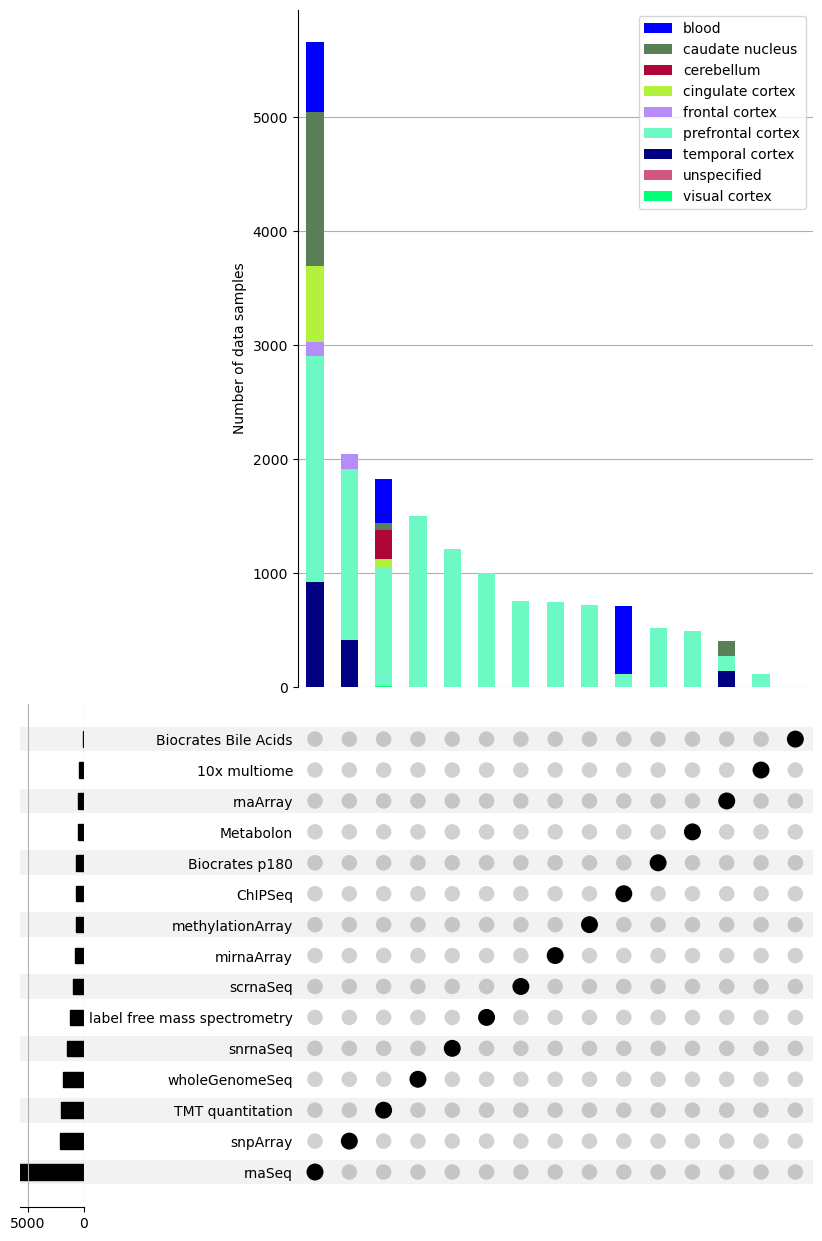

<Figure size 1000x600 with 0 Axes>

In [114]:
from matplotlib import cm
from matplotlib import pyplot as plt

from upsetplot import UpSet
from upsetplot import from_memberships

rosmap_ups = from_memberships(rosmap_gold_bio.assay.str.split(","), data=rosmap_gold_bio)

upset = UpSet(rosmap_ups, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="tissue", colors=ros_colors, title="Number of data samples", elements=20
)
upset.plot()
plt.figure(figsize=(10,6))


plt.suptitle("ROSMAP assay data per individual")
plt.show()